In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
# Add the project root (toy-wm directory) to sys.path so we can import src as a package
# This allows relative imports within the package to work correctly
# Assumes notebook is run from the project root directory
project_root = os.getcwd()  # or use: os.path.dirname(os.path.abspath(''))
if project_root not in sys.path:
    sys.path.insert(0, project_root)




In [14]:
dict(cfg)

{'model': {'model_id': None, 'width': 24, 'height': 24, 'T': 1000, 'in_channels': 3, 'n_window': 7, 'patch_size': 1, 'n_heads': 12, 'd_model': 384, 'n_blocks': 12, 'bidirectional': True, 'nocompile': False, 'checkpoint': None},
 'train': {'lr1': 0.002, 'lr2': 3e-05, 'betas': [0.9, 0.95], 'weight_decay': 1e-05, 'max_steps': 26000, 'batch_size': 32, 'noclip': False, 'duration': 1, 'fps': 7, 'in_channels': 3, 'debug': False},
 'wandb': {'name': 'toy-wm', 'project': None, 'run_name': None}}

In [ ]:
from src.config import Config

cfg = Config.from_yaml('configs/config.yaml')


In [9]:
cfg

{'model': {'model_id': None, 'width': 24, 'height': 24, 'T': 1000, 'in_channels': 3, 'n_window': 7, 'patch_size': 1, 'n_heads': 12, 'd_model': 384, 'n_blocks': 12, 'bidirectional': True, 'nocompile': False, 'checkpoint': None}, 'train': {'lr1': 0.002, 'lr2': 3e-05, 'betas': [0.9, 0.95], 'weight_decay': 1e-05, 'max_steps': 26000, 'batch_size': 32, 'noclip': False, 'duration': 1, 'fps': 7, 'in_channels': 3, 'debug': False}, 'wandb': {'name': 'toy-wm', 'project': None, 'run_name': None}}

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch as t

# Import using absolute path from src package
from src.models.dit_dforce import get_model

state_dict = t.load('./experiments/20251103_105742/model.pt', map_location='mps')


In [3]:
model = get_model(24, 24, patch_size=4, n_blocks=2, n_window=1, bidirectional=True, d_model=128, n_heads=8, T=1000)
model.load_state_dict(state_dict)
model.eval()

using attention slow
using attention slow


CausalDit(
  (frame_rope): FrameRoPE()
  (blocks): ModuleList(
    (0-1): 2 x CausalBlock(
      (norm1): AdaLN(
        (fc): Linear(in_features=128, out_features=256, bias=True)
      )
      (selfattn): AttentionSlow(
        (rope): FrameRoPE()
      )
      (gate1): Gate(
        (fc_c): Linear(in_features=128, out_features=128, bias=True)
      )
      (norm2): AdaLN(
        (fc): Linear(in_features=128, out_features=256, bias=True)
      )
      (geglu): GEGLU(
        (up_proj): Linear(in_features=128, out_features=512, bias=True)
        (up_gate): Linear(in_features=128, out_features=512, bias=True)
        (down): Linear(in_features=512, out_features=128, bias=True)
        (nonlin): GELU(approximate='none')
      )
      (gate2): Gate(
        (fc_c): Linear(in_features=128, out_features=128, bias=True)
      )
    )
  )
  (patch): Patch(
    (conv): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (flatten): Flatten(start_dim=3, end_dim=-1)
  )
  (norm): AdaLN(
    (

In [4]:
from src.trainers.diffusion_forcing import sample
import inspect
inspect.getsource(sample)
import matplotlib.pyplot as plt

z = sample(model, t.randn((100, 1, 3, 24, 24), device='mps'), actions=t.zeros(100, 1, dtype=t.int32, device="mps"), num_steps=8)
z = z.cpu()*std + mean

num_images = 100
img_h, img_w = z.shape[-2], z.shape[-1]
grid_size = 10

fig, axes = plt.subplots(grid_size, grid_size, figsize=(12,12))
for idx in range(num_images):
    row = idx // grid_size
    col = idx % grid_size
    img = z[idx, 0].permute(1, 2, 0).clamp(0, 1).cpu().numpy()  # shape: (24, 24, 3)
    axes[row, col].imshow(img)
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

100%|██████████| 8/8 [00:00<00:00,  8.35it/s]


NameError: name 'std' is not defined

In [11]:
from src.datasets.pong1m import get_loader

loader, pred2frame = get_loader(duration=1, fps=6, mode='-1,1')
frames, actions = next(iter(loader))
frames = pred2frame(frames)


2604 batches


tensor([128, 128, 128], dtype=torch.uint8)


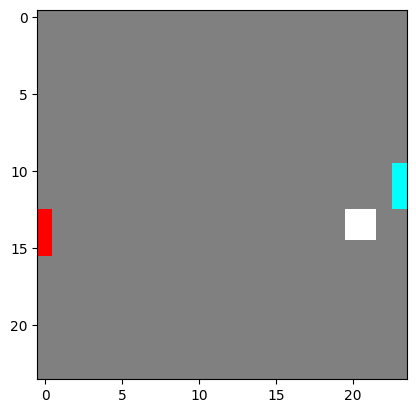

In [12]:
from matplotlib import pyplot as plt
print(frames[0, 0, :, 0, 0])
plt.imshow(frames[0, 0].permute(1, 2, 0))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


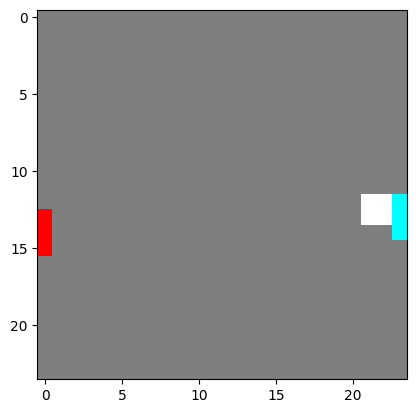

In [30]:
from einops import rearrange
b, dur, c, h, w = frames.shape
z = rearrange(frames, "b dur c h w -> (b dur h w) c")
mask = (z == t.tensor([6, 24, 24], dtype=z.dtype)).all(dim=1)
z = (z-0.5)*2
z[mask] = 0
z2 = z.reshape(*shape) # this reshape actually breaks things
z = rearrange(z, "(b dur h w) c -> b dur c h w", b=b, dur=dur, c=c, h=h, w=w)
#print((z2 == z).all())
plt.imshow((z[0, 0]/2 + 0.5).permute(1, 2, 0))
plt.show()

In [4]:
from torch.nn import functional as F
from tqdm import tqdm

@t.no_grad()
def sample(v, z, frames, actions, num_steps=10, uniform=False, device="mps"):
    if uniform: 
        ts = 1 - t.linspace(0, 1, num_steps, device=device)
    else:
        ts = 1 - F.sigmoid(t.randn(num_steps, device=device).msort())
    #print(ts)
    z_prev = z.clone()
    z_prev = z_prev.to("mps")
    for i in tqdm(range(len(ts)-1)):
        t_cond = ts[i].repeat(z_prev.shape[0], 1)
        z_prev = z_prev + (ts[i] - ts[i+1])*v(z_prev.to("mps"), frames[:, :-1].to("mps"), actions.to("mps"), t_cond.to("mps")) 
    return z_prev

In [5]:
model.to("mps")
z =sample(model, t.randn_like(frames), frames, actions)

100%|██████████| 9/9 [00:03<00:00,  2.67it/s]


In [6]:
z = z.cpu()*std + mean

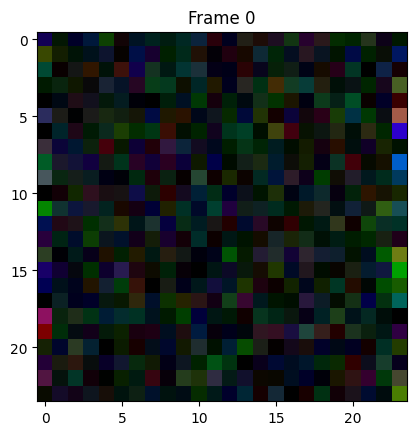

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# z[0] shape: (num_frames, height, width, 3), where num_frames = frames.shape[1]
frames_np = z[0].permute(0, 2, 3, 1).clamp(0, 1).cpu().numpy()  # shape: (num_frames, height, width, 3)

fig, ax = plt.subplots()
im = ax.imshow(frames_np[0])
ax.set_title('Frame 0')

def animate(i):
    im.set_data(frames_np[i])
    ax.set_title(f'Frame {i}')
    return [im]

ani = animation.FuncAnimation(
    fig, animate, frames=frames_np.shape[0],
    interval=200, blit=True, repeat=True
)

plt.show()

# Optional: To save the gif uncomment below (requires pillow, install with `pip install pillow`)
ani.save("sample.gif", writer="pillow")
